**Implement Recurrent Neural Network (RNN) / LSTM for time series or text data**

*Baseline Code Implementation*

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Starting training...
Epoch 1/20
487/487 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0549 - val_loss: 0.0542
Epoch 2/20
487/487 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0209 - val_loss: 0.0224
Epoch 3/20
487/487 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0175 - val_loss: 0.0150
Epoch 4/20
487/487 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0164 - val_loss: 0.0133
Epoch 5/20
487/487 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0159 - val_loss: 0.0132
Epoch 6/20
487/487 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0156 - val_loss: 0.0130
Epoch 7/20
487/487 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0154 - val_loss: 0.0131
Epoch 8/20
487/487 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0152 - val_loss: 0.0132
Epoch 9/20
487/487 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0152 - val_loss: 0.0132
Epoch 10/20
487/487 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0151 - val_loss: 0.0133
Epoch 11/20
487/487 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0150 - val_loss: 0.0130
Epoch 12/20
487/487 ━━━━━━━━━━━

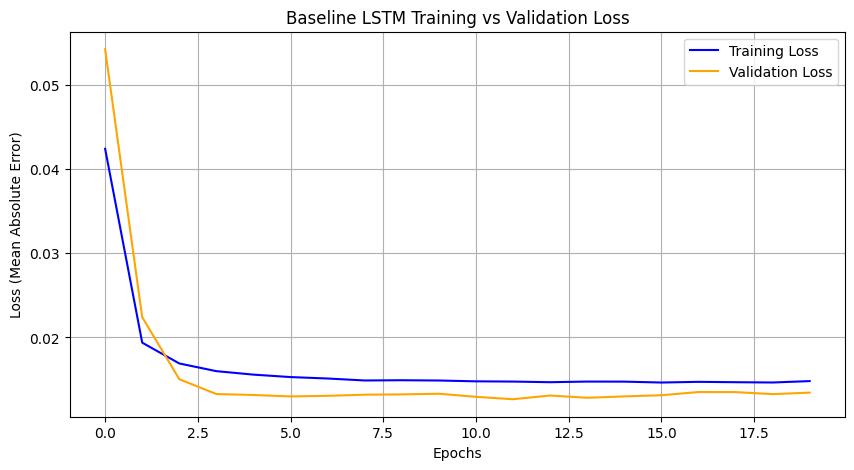

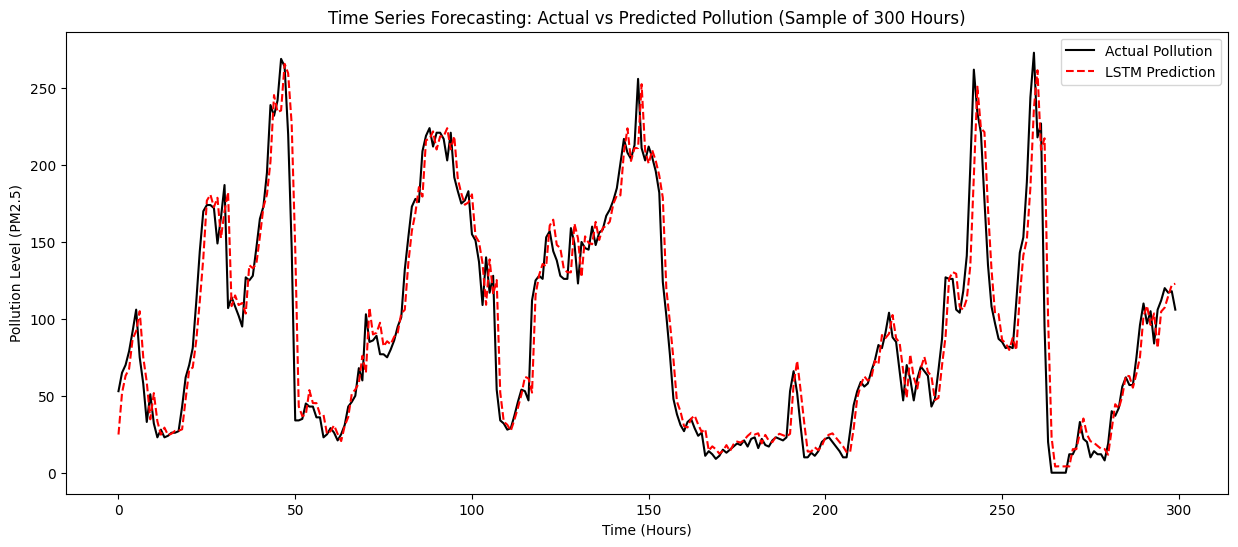

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 1. LOAD DATASET
# Assumes the file 'LSTM-Multivariate_pollution.csv' is in your current directory
df = pd.read_csv('LSTM-Multivariate_pollution.csv', index_col='date')
df.index = pd.to_datetime(df.index)

# 2. DATA PREPROCESSING
# Label encoding for the categorical wind direction column
encoder = LabelEncoder()
df['wnd_dir'] = encoder.fit_transform(df['wnd_dir'])

# Function to transform series into a supervised learning format (t-1 predicts t)
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df_temp = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df_temp.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t)
    for i in range(0, n_out):
        cols.append(df_temp.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan: agg.dropna(inplace=True)
    return agg

# Scaling all features to [0, 1] range (Crucial for LSTM performance)
values = df.values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# Reframing as supervised: Using the past 1 hour to predict the current pollution
reframed = series_to_supervised(scaled, 1, 1)
# Drop columns of other variables at time (t) that we aren't predicting
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)

# 3. TRAIN-TEST SPLIT
values = reframed.values
n_train_hours = 365 * 24 * 4  # First 4 years for training
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# Split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# Reshape input to be 3D [samples, timesteps, features] for LSTM
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# 4. MODEL ARCHITECTURE (Baseline LSTM)
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2)) # Prevents overfitting
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# 5. TRAINING
print("Starting training...")
history = model.fit(train_X, train_y, epochs=20, batch_size=72,
                    validation_data=(test_X, test_y), verbose=1, shuffle=False)

# 6. EVALUATION & METRICS
yhat = model.predict(test_X)
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Invert scaling to get actual pollution values (PM2.5)
inv_yhat = np.concatenate((yhat, test_X_reshaped[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)[:,0]

test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X_reshaped[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)[:,0]

# Mathematical Metrics Output
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
r2 = r2_score(inv_y, inv_yhat)

print("\n--- PERFORMANCE METRICS ---")
print(f"1. Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"2. R-squared (R²) Accuracy: {r2:.4f} (or {r2*100:.2f}%)")

# 7. VISUALS
# Visual 1: Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Baseline LSTM Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Mean Absolute Error)')
plt.legend()
plt.grid(True)
plt.show()

# Visual 2: Actual vs Predicted (Sample for clarity)
plt.figure(figsize=(15, 6))
plt.plot(inv_y[:300], label='Actual Pollution', color='black', linewidth=1.5)
plt.plot(inv_yhat[:300], label='LSTM Prediction', color='red', linestyle='--', linewidth=1.5)
plt.title('Time Series Forecasting: Actual vs Predicted Pollution (Sample of 300 Hours)')
plt.xlabel('Time (Hours)')
plt.ylabel('Pollution Level (PM2.5)')
plt.legend()
plt.show()

*Hyperparameter Tuning*

Training Optimized Model...
Epoch 1/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0426 - val_loss: 0.0301 - learning_rate: 0.0010
Epoch 2/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0231 - val_loss: 0.0260 - learning_rate: 0.0010
Epoch 3/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0191 - val_loss: 0.0175 - learning_rate: 0.0010
Epoch 4/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0168 - val_loss: 0.0147 - learning_rate: 0.0010
Epoch 5/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0163 - val_loss: 0.0138 - learning_rate: 0.0010
Epoch 6/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0162 - val_loss: 0.0153 - learning_rate: 0.0010
Epoch 7/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0159 - val_loss: 0.0161 - learning_rate: 0.0010
Epoch 8/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0160 - val_loss: 0.0158 - learning_rate: 0.0010
Epoch 9/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0153 - val_loss: 0.0133 - lear

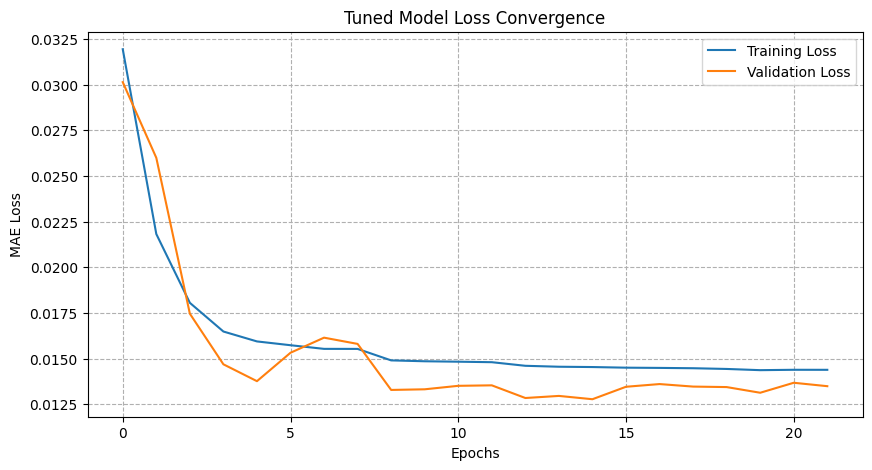

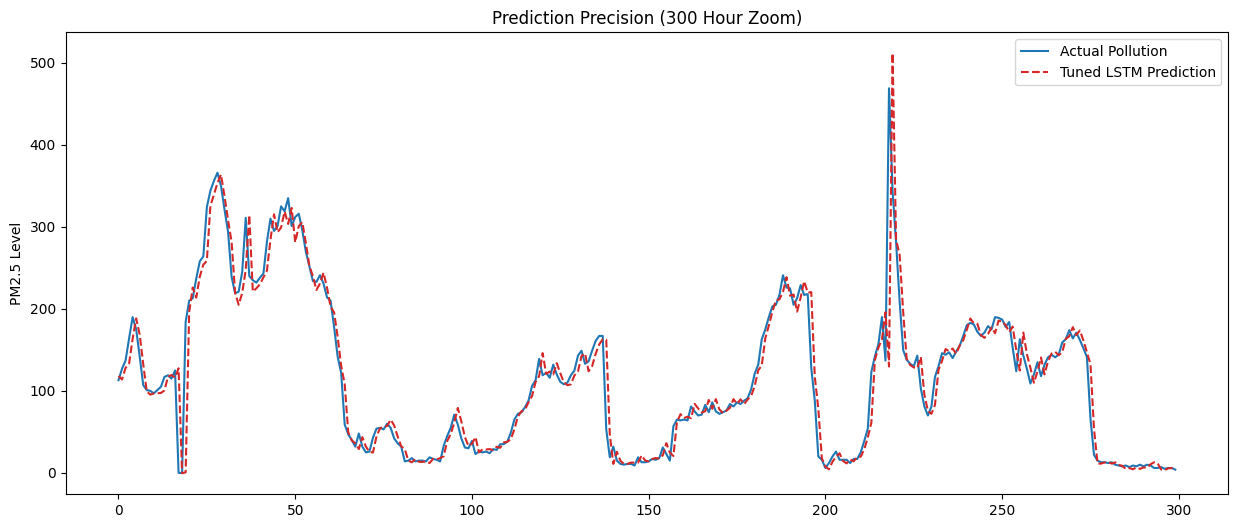

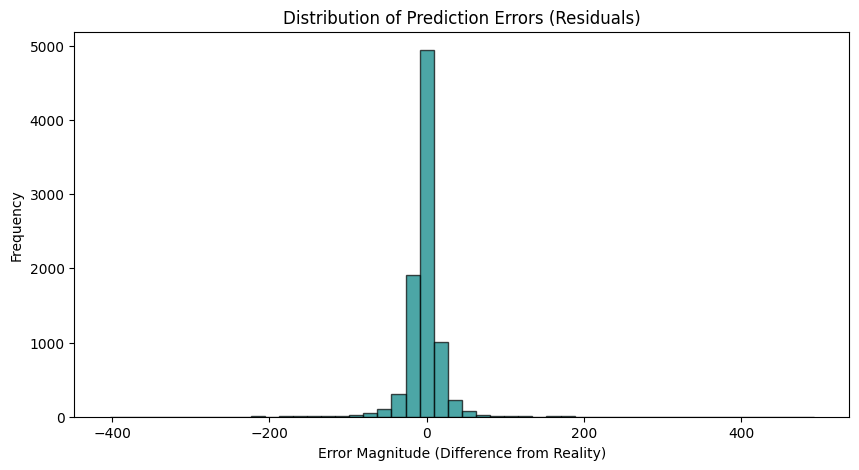

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# 1. LOAD AND PREPROCESS
df = pd.read_csv('LSTM-Multivariate_pollution.csv', index_col='date')
df.index = pd.to_datetime(df.index)

# Encoding categorical wind direction
encoder = LabelEncoder()
df['wnd_dir'] = encoder.fit_transform(df['wnd_dir'])

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df_temp = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df_temp.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df_temp.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan: agg.dropna(inplace=True)
    return agg

values = df.values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# TUNING: Increased temporal context (lookback of 3 hours)
n_hours = 3
n_features = 8
reframed = series_to_supervised(scaled, n_hours, 1)

# Ensure we only keep the features and the target 'pollution' at time (t)
n_obs = n_hours * n_features
reframed = reframed.iloc[:, :n_obs + 1]

# 2. SPLIT DATA
values = reframed.values
n_train_hours = 365 * 24 * 4
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]

# Reshape for LSTM [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

# 3. TUNED STACKED ARCHITECTURE
model = Sequential()
model.add(Input(shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(100, return_sequences=True)) # Layer 1: Captures broad patterns
model.add(Dropout(0.2))
model.add(LSTM(50))                          # Layer 2: Refines features
model.add(Dropout(0.2))
model.add(Dense(1))

# Optimized Learning Rate
optimizer = Adam(learning_rate=0.001)
model.compile(loss='mae', optimizer=optimizer)

# 4. OPTIMIZATION CALLBACKS
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# 5. TRAINING
print("Training Optimized Model...")
history = model.fit(
    train_X, train_y,
    epochs=50,
    batch_size=64,
    validation_data=(test_X, test_y),
    verbose=1,
    shuffle=False,
    callbacks=[early_stop, reduce_lr]
)

# 6. EVALUATION
yhat = model.predict(test_X)
test_X_reshaped = test_X.reshape((test_X.shape[0], n_hours*n_features))

# Invert scaling for metrics
inv_yhat = np.concatenate((yhat, test_X_reshaped[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)[:,0]

test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X_reshaped[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)[:,0]

# FINAL METRICS
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
r2 = r2_score(inv_y, inv_yhat)

print("\n" + "="*30)
print("   OPTIMIZED MODEL RESULTS")
print("="*30)
print(f"1. RMSE: {rmse:.4f}")
print(f"2. R-Squared Accuracy: {r2:.4f} (or {r2*100:.2f}%)")
print("="*30)

# 7. NECESSARY VISUALS
# Visual 1: Loss Convergence
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Tuned Model Loss Convergence')
plt.ylabel('MAE Loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True, linestyle='--')
plt.show()

# Visual 2: Forecast Precision (Zoom-in)
plt.figure(figsize=(15, 6))
plt.plot(inv_y[500:800], label='Actual Pollution', color='#1f77b4')
plt.plot(inv_yhat[500:800], label='Tuned LSTM Prediction', color='#d62728', linestyle='--')
plt.title('Prediction Precision (300 Hour Zoom)')
plt.ylabel('PM2.5 Level')
plt.legend()
plt.show()

# Visual 3: Residual Analysis (Error Distribution)
residuals = inv_y - inv_yhat
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=50, color='teal', edgecolor='black', alpha=0.7)
plt.title('Distribution of Prediction Errors (Residuals)')
plt.xlabel('Error Magnitude (Difference from Reality)')
plt.ylabel('Frequency')
plt.show()